<a href="https://colab.research.google.com/github/poedator/demo_notebooks/blob/main/beeVwasp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание: Классификация пчёл и ос <br>(в TF2 без tf.keras)

Напишите нейронную сеть по классификации пчёл и ос, БЕЗ использования библиотеки Keras (используйте только TensorFlow 2.0). Фото пчёл находятся в папке bee, а фото ос находятся в папке wasp.


In [1]:
# Устанавливаем tf 2.0 вместо 2.4
!pip install tensorflow==2.0 -q
!pip install tensorflow-datasets==3.2.1 -q  # to match TF=2.0

     |████████████████████████████████| 86.3MB 46kB/s 
     |████████████████████████████████| 450kB 60.6MB/s 
     |████████████████████████████████| 51kB 3.3MB/s 
     |████████████████████████████████| 3.8MB 57.3MB/s 
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
     |████████████████████████████████| 3.4MB 6.5MB/s 


In [2]:
import numpy as np
import os
import pathlib
import time
from tqdm.notebook import tqdm
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print (f"TF version: {tf.__version__}")

TF version: 2.0.0


# Loading and processing dataset
(based on https://www.tensorflow.org/tutorials/load_data/images)


In [3]:
# параметры загрузки и обработки датасета

# data_dir_string = 'C:\\temp\\bees_wasps'  # dataset files location = Home
data_dir_string = './beeVSwasp'  # dataset files location - Colab

img_size, num_channels = (224, 224), 3  # target for resizing

val_size = 0.1  # validation dataset fraction
batch_size = 32

In [4]:
# Download and extract dataset (Colab only)
!mkdir $data_dir_string
!gdown https://drive.google.com/uc?id=1CNykvqE1VkViCcqchJf2dYWD3MzlTGUt
!unzip -qn beeVSwasp.zip -d $data_dir_string
!ls $data_dir_string -l 

Downloading...
From: https://drive.google.com/uc?id=1CNykvqE1VkViCcqchJf2dYWD3MzlTGUt
To: /content/beeVSwasp.zip
118MB [00:01, 85.8MB/s]
total 272
drwxr-xr-x 2 root root 135168 Nov 17 15:18 bee
drwxr-xr-x 2 root root 135168 Nov 17 15:19 wasp


In [5]:
# Create dataset of filenames
data_dir = pathlib.Path(data_dir_string)

image_count = len(list(data_dir.glob('*/*.jpg')))
class_names = sorted([item.name for item in data_dir.glob('*')])

print (f"Detected {image_count} images in {len(class_names)} classes:")
for cn in class_names:
    print (f"{cn+':':<5} {len(list(data_dir.glob(f'{cn}/*')))}")

path_ds = tf.data.Dataset.from_tensor_slices(list(map(str, list(data_dir.glob('*/*.jpg')))))
path_ds = path_ds.shuffle(buffer_size=image_count, reshuffle_each_iteration=True)


Detected 4595 images in 2 classes:
bee:  2469
wasp: 2127


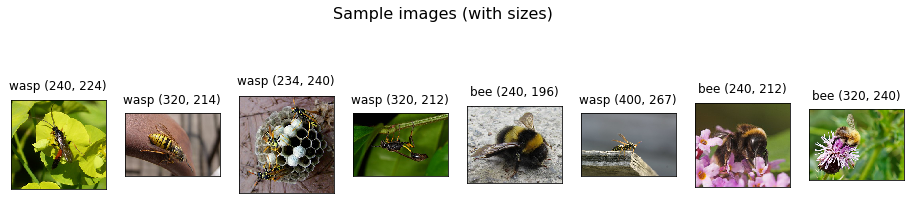

In [6]:
# Examples of class images (before resize)

fig = plt.figure(figsize=(16,4))
shape=(1,8)
for i, f in enumerate(path_ds.take(8)):
    f = f.numpy().decode('utf-8')
    img = Image.open(f)

    ax = fig.add_subplot(shape[0], shape[1], i+1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    img_title = f"{f.split(os.path.sep)[-2]} {img.size}"
    ax.set_title(img_title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.matshow(img)
fig.suptitle("Sample images (with sizes)", fontsize=16);

In [7]:
# Create datasets of images

def load_image(path, img_size, num_channels=3):
    path_parts = tf.strings.split(path, os.path.sep)
    label = tf.cast(path_parts[-2] == tf.constant(class_names[1]), tf.int64)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255
    return (img, label)

img_ds = path_ds.map(lambda x: load_image(x, img_size, num_channels))

train_ds = img_ds.skip(int(image_count * val_size))
val_ds   = img_ds.take(int(image_count * val_size))

tf.data.experimental.cardinality(path_ds).numpy(), tf.data.experimental.cardinality(img_ds).numpy()

(4595, 4595)

In [8]:
# Show number of class items in each dataset

def ds_class_cnt(ds):
    counter = [0,0]
    for img, label in ds:
        counter[label] +=1
    return (counter)

print (f'Classes counts:  {class_names[0]}  {class_names[1]}')
for ds_name, ds in zip (['img_ds', 'train_ds', 'val_ds'], [img_ds, train_ds, val_ds]):
    class_cnt = ds_class_cnt(ds)
    print (f'{ds_name:<9}:      {class_cnt[0]:>4}  {class_cnt[1]:>4}')

Classes counts:  bee  wasp
img_ds   :      2469  2126
train_ds :      2212  1924
val_ds   :       255   204


In [9]:
# configure datasets for model training
def configure_ds(ds):
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=1000)
    return ds

train_ds = configure_ds(train_ds)
val_ds = configure_ds(val_ds)

# CNN classification model

### Layer classes

In [10]:
class MyConv2D():
    """
    Class for 2D convolution, replicating basic features of tf.keras.layers.Conv2d
    """
    def __init__(self, filters, kernel_size, in_channels, stride, activation, padding='SAME'):
        w_init = tf.random_normal_initializer(
                    stddev=tf.sqrt(2 / (kernel_size[0] * kernel_size[1] * in_channels)))
        self.W = tf.Variable(w_init(dtype=tf.float32,
                             shape=[*kernel_size, in_channels, filters]), trainable=True)
        self.b = tf.Variable(tf.zeros([filters]), dtype=tf.float32, trainable=True)
        self.stride = stride
        self.activation = activation
        self.padding = padding
        self.trainable = [self.W, self.b]
        self.trainable_layer = True

    def __call__(self, X):
        out = tf.nn.conv2d(X, self.W, self.stride, self.padding,)
        out = tf.add(out, self.b)
        return self.activation(out)


class MyDense():
    """
    Class for dense layer, replicating basic features of tf.keras.layers.Dense
    """
    def __init__(self, units, in_size, activation):
        self.activation = activation
        if 'sigmoid' in self.activation.__name__:
            w_init = tf.random_normal_initializer(stddev=tf.sqrt(6 / (units + in_size)))  # Glorot
        elif 'relu' in self.activation.__name__:
            w_init = tf.random_normal_initializer(stddev=tf.sqrt(2 / (units + in_size)))  # Kaiming
        else:
            w_init = tf.random_normal_initializer(stddev=tf.sqrt(2 / (units + in_size)))  # Kaiming

        self.W = tf.Variable(w_init(shape=[in_size, units], dtype="float32"), trainable=True)
        self.b = tf.Variable(tf.zeros([units]), dtype=tf.float32, trainable=True)
        self.trainable = [self.W, self.b]
        self.trainable_layer = True

    def __call__(self, X):
        out = self.activation(tf.matmul(X, self.W) + self.b)
        return out


class MyFlatten():
    """
    Class for flattening, replicating basic features of tf.keras.layers.Flatten
    """
    def __init__(self):
        self.trainable = []
        self.trainable_layer = False

    def __call__(self, X):
        return tf.reshape(X, (X.shape[0], -1))       

### Metrics and optmizer

In [11]:
def sparse_categorical_crossentropy (y_true, y_pred):
    correct_logits = tf.math.reduce_sum(y_pred * tf.one_hot(y_true, axis = 1, depth=2), axis = 1)
    normalized_logits =  correct_logits / tf.math.reduce_sum(y_pred, axis=1)
    return - tf.math.log(normalized_logits)

In [12]:
class My_SGD_optimizer():
    """ Simple SGD optimizer. """
    def __init__(self, lr=0.001):
        self.lr = lr

    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            var.assign_sub(grad * self.lr)

### Model class definition

In [13]:
class MyModel():
    """
    Class of simple sequential NN model
    """
    def __init__(self, layers, lr=0.001):
        self._layers = layers
        self._trainable_layers = [l for l in layers if l.trainable_layer]
        self._trainable_variables = [v for l in self._layers for v in l.trainable]
        self.lr = lr
        print (f"Model initialized with {len(self._layers)} layers "
               f"({len(self._trainable_layers)} trainable) and "
               f"{sum([np.prod(v.shape) for v in self._trainable_variables])} "
               "trainable params.\n")
    
    @tf.function
    def _forward(self, X):
        for layer in self._layers:
            X = layer(X)
            # print (X.shape)
        return (X)

    def predict(self, X):
        prediction = self._forward(X)        
        return tf.argmax(prediction, axis=1)
    
    def fit(self, train_data, val_data, epochs, loss, optimizer, early_stop=3):
        """аналог tf.Keras.Model.fit"""

        self.history = {'train_loss': [], 'train_acc': [],
                        'val_loss': [], 'val_acc': []}
        
        best_epoch, best_val_loss, best_layers = 0, 1000, None
        
        for e in range(1, epochs + 1):
            start_time = time.time()
            train_data = train_data.shuffle(buffer_size=1000)
            
            # training
            cum_loss, count, correct = 0, 0, 0
            for X, y in train_data:
                with tf.GradientTape() as tape:
                    prediction = self._forward(X)
                    loss_value = loss(y, prediction)
                gradients = tape.gradient(loss_value, self._trainable_variables)
                optimizer.apply_gradients(zip(gradients, self._trainable_variables))

                cum_loss += tf.math.reduce_sum(loss_value)
                count += X.shape[0]
                correct += tf.math.reduce_sum(
                    tf.cast(tf.argmax(prediction, axis=1) == y, tf.int32))

            self.history['train_loss'].append((cum_loss / count).numpy())
            self.history['train_acc'].append((correct / count).numpy())

            # validation
            cum_loss, count, correct = 0, 0, 0            
            for X, y in val_data:
                prediction = self._forward(X)
                loss_value = loss(y, prediction)
                cum_loss += tf.math.reduce_sum(loss_value)
                count += X.shape[0]
                correct += tf.math.reduce_sum(
                    tf.cast(tf.argmax(prediction, axis=1) == y, tf.int32))

            self.history['val_loss'].append((cum_loss / count).numpy())
            self.history['val_acc'].append((correct / count).numpy())
            
            # вывод результата эпохи
            print(f"Ep.{e:>2}: Train loss:{self.history['train_loss'][-1]:.3f} "
                  f"acc:{self.history['train_acc'][-1]:.3f};  "
                  f"Val loss:{self.history['val_loss'][-1]:.3f} "
                  f"acc:{self.history['val_acc'][-1]:.3f};  "
                  f"time:{(time.time() - start_time):.2f}s. ", end='')
            
            # Запись лучшего результата
            if self.history['val_loss'][-1] < best_val_loss:
                best_val_loss = self.history['val_loss'][-1]
                best_epoch = e
                best_layers = self._layers.copy()
                print ('<- improved')
            else:
                print ()
                
            # early stopping callback
            if e > early_stop + 1 and \
                    min(self.history['val_loss'][-early_stop:]) > \
                        min(self.history['val_loss']):
                print (f"\nEalry stopping after epoch {e}! \n"
                       f"Weights restored to epoch {best_epoch}.")
                self._layers = best_layers
                break

        return self.history

In [14]:
# ПОСТРОЕНИЕ МОДЕЛИ
model = MyModel([MyConv2D(16, (3,3), 3, 2, tf.nn.relu),
                 MyConv2D(16, (3,3), 16, 2, tf.nn.relu),
                 MyConv2D(32, (3,3), 16, 2, tf.nn.relu),
                 MyConv2D(64, (3,3), 32, 2, tf.nn.relu),
                 MyConv2D(64, (3,3), 64, 2, tf.nn.relu),
                 MyFlatten(),
                 MyDense(80, 7*7*64, tf.nn.tanh),
                 MyDense(2, 80, tf.nn.sigmoid),
                 ])

# ОБУЧЕНИЕ МОДЕЛИ
# как правило, требуется 20-30 эпох для достижения точности 0,92 - 0,98
# время эпохи ~3c на GPU и ~45c без ускорителя.

history = model.fit(train_ds, val_ds, epochs=50, 
                    loss=sparse_categorical_crossentropy, 
                    optimizer = My_SGD_optimizer(lr=0.001),
                    early_stop=5,
                    )

Model initialized with 8 layers (7 trainable) and 313954 trainable params.

Ep. 1: Train loss:0.683 acc:0.556;  Val loss:0.690 acc:0.512;  time:51.27s. <- improved
Ep. 2: Train loss:0.662 acc:0.592;  Val loss:0.662 acc:0.562;  time:40.09s. <- improved
Ep. 3: Train loss:0.639 acc:0.622;  Val loss:0.607 acc:0.649;  time:46.04s. <- improved
Ep. 4: Train loss:0.588 acc:0.677;  Val loss:0.543 acc:0.732;  time:41.29s. <- improved
Ep. 5: Train loss:0.532 acc:0.736;  Val loss:0.522 acc:0.739;  time:40.34s. <- improved
Ep. 6: Train loss:0.503 acc:0.764;  Val loss:0.493 acc:0.743;  time:40.62s. <- improved
Ep. 7: Train loss:0.478 acc:0.772;  Val loss:0.448 acc:0.795;  time:40.42s. <- improved
Ep. 8: Train loss:0.469 acc:0.780;  Val loss:0.532 acc:0.769;  time:41.01s. 
Ep. 9: Train loss:0.439 acc:0.798;  Val loss:0.405 acc:0.817;  time:40.66s. <- improved
Ep.10: Train loss:0.422 acc:0.807;  Val loss:0.398 acc:0.800;  time:40.66s. <- improved
Ep.11: Train loss:0.393 acc:0.823;  Val loss:0.389 acc:

## Графики динамики обучения

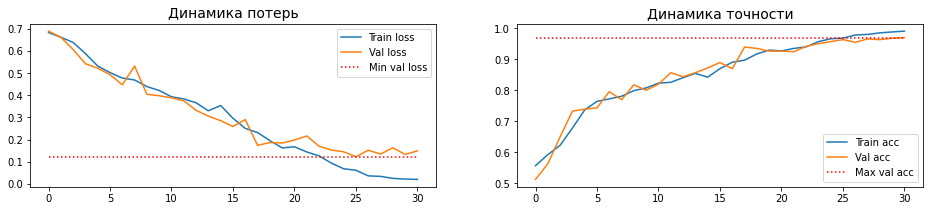

In [15]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,3))

ax0.plot(history['train_loss'], label = 'Train loss')
ax0.plot(history['val_loss'], label = 'Val loss')
ax0.plot([min(history['val_loss'])]*len(history['val_loss']),
         label = 'Min val loss', color='r', linestyle = ':')

# plt.xlabel("epoch")
# plt.ylabel("loss")
# ax0.set_ylim(0, 0.35)
ax0.set_title("Динамика потерь", fontsize=14)
ax0.legend();

ax1.plot(history['train_acc'], label = 'Train acc')
ax1.plot(history['val_acc'], label = 'Val acc')
ax1.plot([max(history['val_acc'])]*len(history['val_acc']), 
         label = 'Max val acc', color='r', linestyle = ':')
# ax1.set_ylim(0.94, 1)
ax1.set_title("Динамика точности", fontsize=14)
ax1.legend();

# Тестирование классификации

image path: beeVSwasp/wasp/4729610962_fc3e53ff70_n.jpg
image class:     wasp
predicted class: wasp
CORRECT!


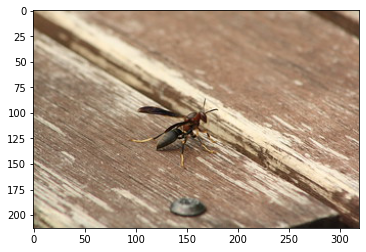

In [16]:
# Тестирование на случайных объектах исходного датасета
# обновите клетку для следующего изображения

path = next(iter(path_ds)).numpy().decode('utf-8')
img, label = load_image (path, img_size, num_channels)

print('image path:', path)
true_class = path.split(os.path.sep)[-2]
print('image class:    ', true_class)
# X = tf.expand_dims(img, axis=0)
# print(model._forward(X))
pred = model.predict(tf.expand_dims(img, axis=0)).numpy()[0]
predicted_class = class_names[pred]
print(f"predicted class: {predicted_class}")
if true_class == predicted_class:
    print ("CORRECT!")
else:
    print ("ERROR :(")
image_original = Image.open(path)
plt.imshow(image_original);